## Multi-modal RAG

Many documents contain a mixture of content types, including text and images. 

Yet, information captured in images is lost in most RAG applications.

With the emergence of multimodal LLMs, like [GPT-4V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG:

`Option 1:` 

* Use multimodal embeddings (such as [CLIP](https://openai.com/research/clip)) to embed images and text
* Retrieve both using similarity search
* Pass raw images and text chunks to a multimodal LLM for answer synthesis 

`Option 2:` 

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve text 
* Pass text chunks to an LLM for answer synthesis 

`Option 3`

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve image summaries with a reference to the raw image 
* Pass raw images and text chunks to a multimodal LLM for answer synthesis   

---

This cookbook highlights `Option 3`. 

* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) with [Chroma](https://www.trychroma.com/) to store raw text and images along with their summaries for retrieval.
* We will use GPT-4V for both image summarization (for retrieval) as well as final answer synthesis from join review of images and texts (or tables).

---

A separate cookbook highlights `Option 1` [here](https://github.com/langchain-ai/langchain/blob/master/cookbook/multi_modal_RAG_chroma.ipynb).

And option `Option 2` is appropriate for cases when a multi-modal LLM cannot be used for answer synthesis (e.g., cost, etc).

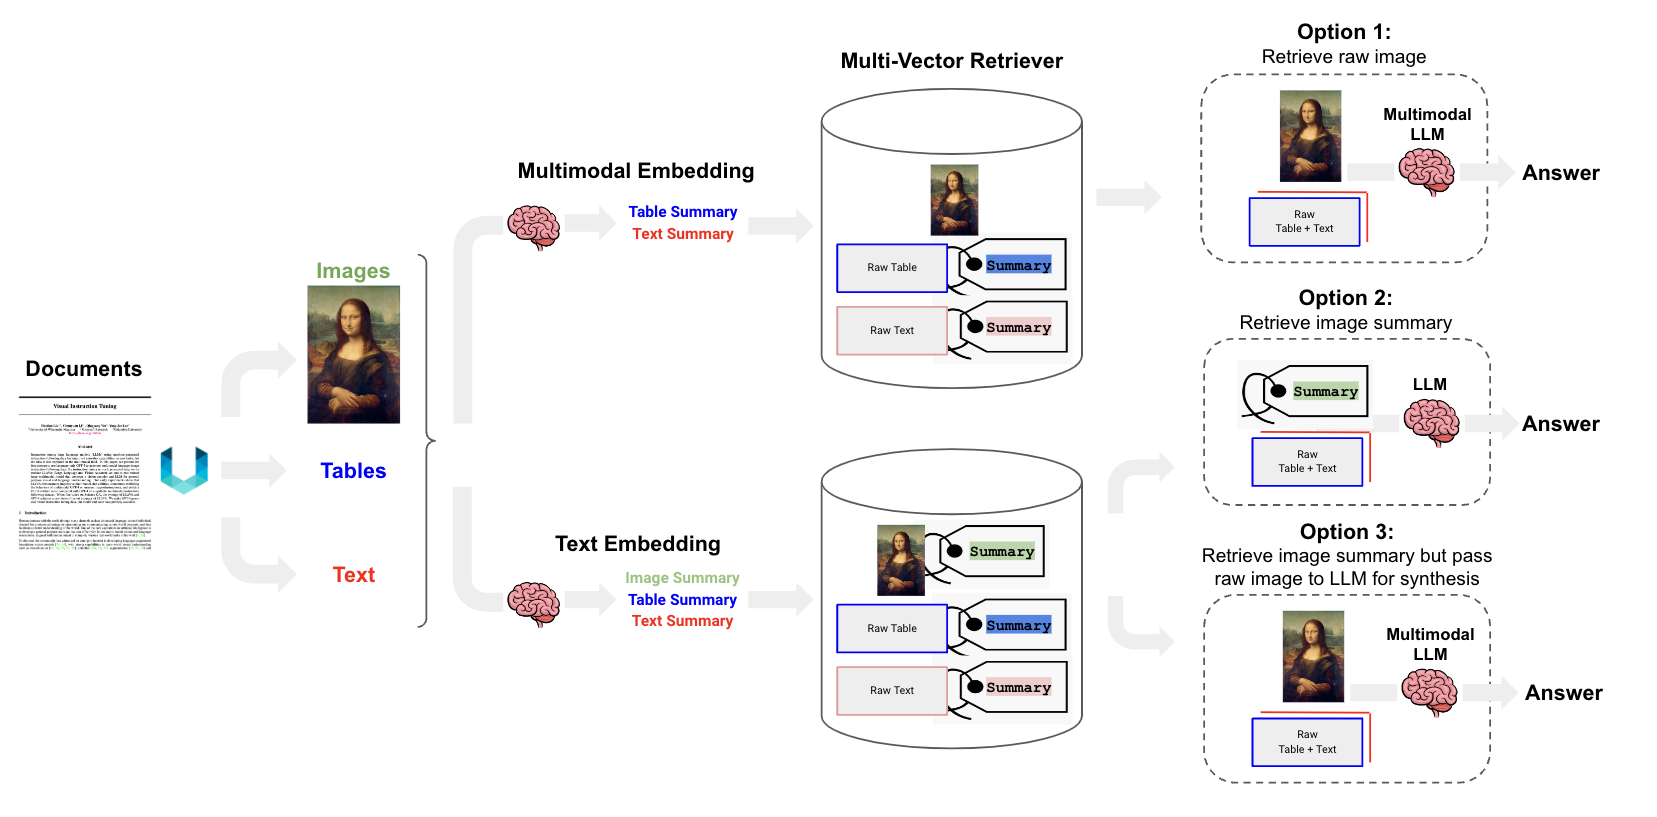

## Packages

In addition to the below pip packages, you will also need `poppler` ([installation instructions](https://pdf2image.readthedocs.io/en/latest/installation.html)) and `tesseract` ([installation instructions](https://tesseract-ocr.github.io/tessdoc/Installation.html)) in your system.

In [ ]:
! pip install -U langchain openai langchain-chroma langchain-experimental

In [ ]:
! pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken

## Data Loading

### Partition PDF tables, text, and images
  
Let's look at a [popular blog](https://cloudedjudgement.substack.com/p/clouded-judgement-111023) by Jamin Ball.

This is a great use-case because much of the information is captured in images (of tables or charts).

We use `Unstructured` to partition it (see [blog post](https://blog.langchain.dev/semi-structured-multi-modal-rag/)).

---

To skip `Unstructured` extraction:

[Here](https://drive.google.com/file/d/1QlhGFIFwEkNEjQGOvV_hQe4bnOLDJwCR/view?usp=sharing) is a zip file with a sub-set of the extracted images and pdf.

If you want to use the provided folder, then simply opt for a [pdf loader](https://python.langchain.com/docs/modules/data_connection/document_loaders/pdf) for the document:

```
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader(path + fname)
docs = loader.load()
tables = [] # Ignore w/ basic pdf loader
texts = [d.page_content for d in docs]
```

In [ ]:
import nltk
nltk.download('punkt')

In [46]:
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf


# Extract elements from PDF
def extract_pdf_elements(path, fname):
    """
    Extract images, tables, and chunk text from a PDF file.
    path: File path, which is used to dump images (.jpg)
    fname: File name
    """
    return partition_pdf(
        filename=path + fname,
        extract_images_in_pdf=False,
        infer_table_structure=True,
        chunking_strategy="by_title",
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
        image_output_dir_path=path,
    )


# Categorize elements by type
def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables and texts.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
    return texts, tables


# File path
fpath = "./pdf blog/"
fname = "jpm_pdf_test_2.pdf"

# Get elements
raw_pdf_elements = extract_pdf_elements(fpath, fname)

# Get text, tables
texts, tables = categorize_elements(raw_pdf_elements)

# Optional: Enforce a specific token size for texts
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=4000, chunk_overlap=0
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

In [51]:
print(tables[4])

Scenarios FX implications 1. Big squeeze USD TWI+3-5% no more hikes but gradual slide in high-for-long USDIUPY 145, - margin compression, high rates drag down growth EURIUSD 1.00-1.03 - Fed cuts 25bp/meeting starting 3Q in response to recession High beta FX leads weakness Best ong and short candidates Long USD, CHF vs. EUR, GBP, Scandis, AUD.NZD 2 Round 2 KO/ Fed at 5.5% is not enough USD TWI+5-7 % - already-sluggish growth hit by higher rates USDIJPY breaks 155 initially, then lower on recession = inflation slide is limited; 2025 deep recession EURIUSD 1.00 = More pain outside the US High beta FX - worst case outcome for low yielders double-digit drawdowns Best long and short candidates Long DXY, short high-beta FX 3. Goldilocks! soft landing USD TWI-8 to -10% - inflation falls in 2024, no added tightening USDIJPY 140 = US growth low 0.5%: no recession in EMU EURIUSD 1.15+ ~ central banks cut towards neutral High beta FX rebounds, funding currencies in G10 and Asia perform even better

## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) to index image (and / or text, table) summaries, but retrieve raw images (along with raw texts or tables).

### Text and Table summaries

We will use GPT-4 to produce table and, optionall, text summaries.

Text summaries are advised if using large chunk sizes (e.g., as set above, we use 4k token chunks).

Summaries are used to retrieve raw tables and / or raw chunks of text.

In [6]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Text summary chain
    model = ChatOpenAI(temperature=0, model="gpt-4",api_key="")
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

In [55]:
print(tables[0])
from unstructured.staging.base import convert_to_csv

tables = [el for el in raw_pdf_elements if el.category == "Table"]
csv_data = convert_to_csv(tables)

# Write to a CSV file
with open('output_tables.csv', 'w', newline='') as csvfile:
    csvfile.write(csv_data)

Stes Scien . USD TH 55% "Notre ee bloke eabghtotng — WaDURY imepnconpsson highs dap dom pos EURWURD 100103 “Fed ats ptnetg vary 3 apne cee gh bs FX end wetness toga er cae mcrae ea. 3 Rood 21 Fed 4 at soph uso rm 57% ‘cy supgon oun hy bert USDPY tt 55 ay en ver oreo isn odes ted 2025 ep rceencn——EURURD 0, Hoe pan otc bo US High FX: nonce cdzon row os ng an st can ese, sha gn e F Tent womans frye pate aml Cert bas ct met ns Mig a Fonds, eg corn 9019 sho pte oven beter ote owas Tor buh USD eo epee rhs Sestog ad tt cates Aecng gs 220 cay Yd Lrg Se, EUR ALD NOW Asan Pv USD “Damage on Recon nt UBD TW 57% Re own 810% US on EU reas aecrason n 0 UsDLPY ow 1 Fedpedis Sou nde EURURD telat, evel 15¢ = ang JPY and OF ences: Long USD ve erie 0 gh bet condos EM gh yldes


TypeError: 'TableChunk' object is not iterable

### Image summaries 

We will use [GPT-4V](https://openai.com/research/gpt-4v-system-card) to produce the image summaries.

The API docs [here](https://platform.openai.com/docs/guides/vision):

* We pass base64 encoded images

In [11]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024, api_key="")

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries

fpath = "./figures1/"
# Image summaries
img_base64_list, image_summaries = generate_img_summaries(fpath)

In [21]:
print(image_summaries[3])

This image is a scatter plot titled "NTM Rev Growth vs NTM Rev Multiple," plotting the relationship between next twelve months (NTM) revenue growth percentage (x-axis) and the NTM revenue multiple (y-axis) for various companies, indicated by their stock ticker symbols. A dotted trend line is shown with an accompanying equation and R-squared value, suggesting a positive correlation between revenue growth and revenue multiple. The graphic is credited to "Clouded Judgement @jaminball" and marked with "ALTIMETER" in the bottom right corner.


### Add to vectorstore

Add raw docs and doc summaries to [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary): 

* Store the raw texts, tables, and images in the `docstore`.
* Store the texts, table summaries, and image summaries in the `vectorstore` for efficient semantic retrieval.

In [20]:
#######
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="mm_rag_cj_blog", embedding_function=OpenAIEmbeddings(api_key="")
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts_4k_token, #mistake corrected i think. its was 'texts' which didnt make sence
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

In [26]:
print(retriever_multi_vector_img.invoke("What is the purpose of the article?"))

# this retivies everything, it needs to be splitted and made sence of. much abstraction in the way

["7/26/24, 3:49 PM\n\nClouded Judgement 11.10.23 - by Jamin Ball\n\nClouded Judgement 11.10.23 - OpenAI Updates + Datadog Gives the All-Clear?\n\nJAMIN BALL\n\nNOV 10, 2023\n\nQ\n\n40\n\nD2\n\n2\n\nEvery week I’ll provide updates on the latest trends in cloud soware companies. Follow\n\nalong to stay up to date!\n\nType your email...  Subscribe \n\nOpenAI Updates\n\nOpenAI had their big developer day this week, and I wanted to call out two key announcements (and trends): increasing context windows and decreasing costs.\n\nWhen I think about the monetization of AI (and which “layers” monetize rst) I’ve always thought it would follow the below order, with each layer lagging the one that\n\ncomes before it.\n\n1. Raw silicon (chips like Nvidia bought in large quantities to build out infra to\n\nservice upcoming demand).\n\n2. Model providers (OpenAI, Anthropic, etc as companies start building out Al).\n\n2. Model providers (OpenAI, Anthropic, etc as companies start building out AI).\n\n3.

## RAG

### Build retriever

We need to bin the retrieved doc(s) into the correct parts of the GPT-4V prompt template.

In [23]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024, api_key="")

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

### Check

Examine retrieval; we get back images that are relevant to our question.

In [24]:
# Check retrieval
query = "Give me company names that are interesting investments based on EV / NTM and NTM rev growth. Consider EV / NTM multiples vs historical?"
docs = retriever_multi_vector_img.invoke(query, limit=6)

# We get 4 docs
len(docs)

4

In [39]:
# Check retrieval
query = "What are the EV / NTM and NTM rev growth for MongoDB, Cloudflare, and Datadog?"
docs = retriever_multi_vector_img.invoke(query, limit=6)

# We get 4 docs
len(docs)
print(docs[0][0])

7


In [44]:
print(docs)

['7/26/24, 3:49 PM\n\nClouded Judgement 11.10.23 - by Jamin Ball\n\nGrowth Adjusted EV / NTM Revenue (EV / NTM Rev / NTM Growth) Le Median: 0.4% | 93x ax, og | II Liitititii iti 32 Fd 6 Palo Alto Hubspot ‘Agora Paycom Digital Ocean Workday Cloucflare Clouded Judgement ajaminball ALTIMETER EV / NTM FCF\n\nThe line chart shows the median of all companies with a FCF multiple >0x and <100x. I\n\ncreated this subset to show companies where FCF is a relevant valuation metric.\n\nEV / NTM FCF Multiples 70.0x 60.0x 50.0x 40.0x 40.1x 30.0x 29.8x 20.0x 10.0x Ox 1/1/15 1/1/16 1/1/17 1/1/18 1/1/19 1/1/20 1/1/21 1/1/22 1/1/23 === FCF Positive & <100x Multiple Median ——=LT Average Clouded Judgement @jaminball ALTIMETER\n\nCompanies with negative NTM FCF are not listed on the chart\n\nhttps://cloudedjudgement.substack.com/p/clouded-judgement-111023\n\n9/14\n\n7/26/24, 3:49 PM\n\nClouded Judgement 11.10.23 - by Jamin Ball\n\nEV / NTM FCF ‘ax TTT TTT eee adMesing; 33x, x ss Pe Ss ie Oey She LOK se PES 


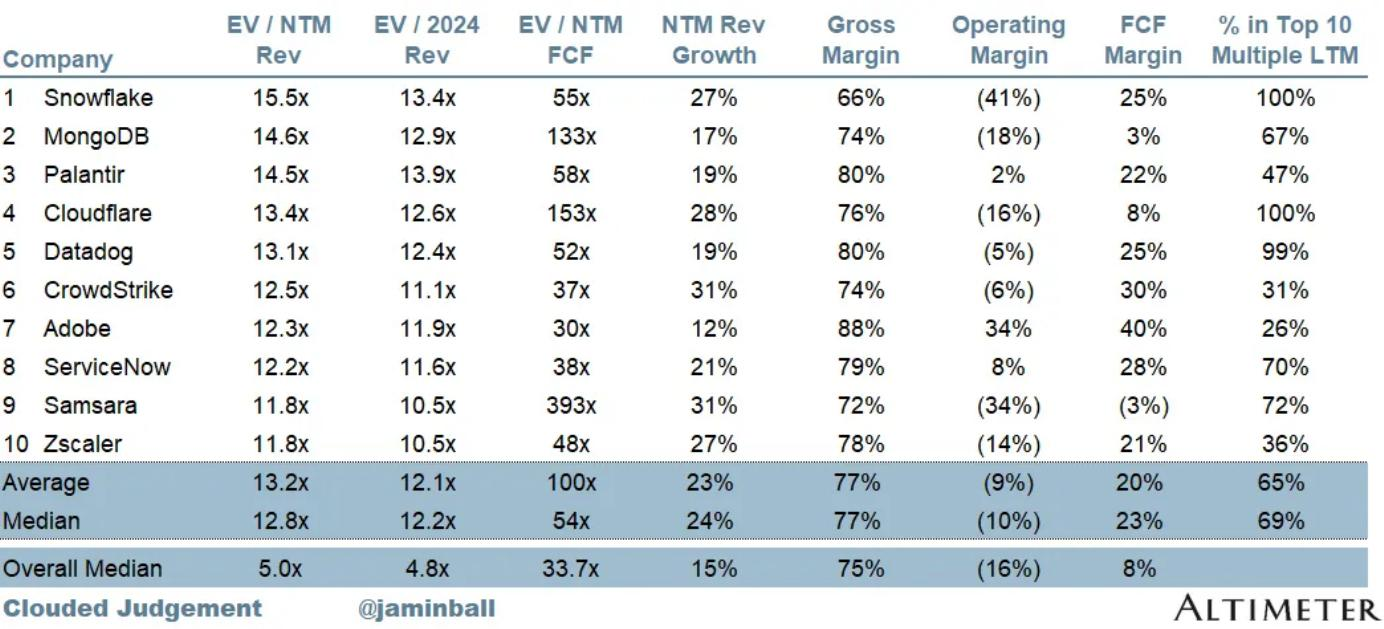

In [34]:
# We get back relevant images
plt_img_base64(docs[2])

### Sanity Check

Why does this work? Let's look back at the image that we stored ...


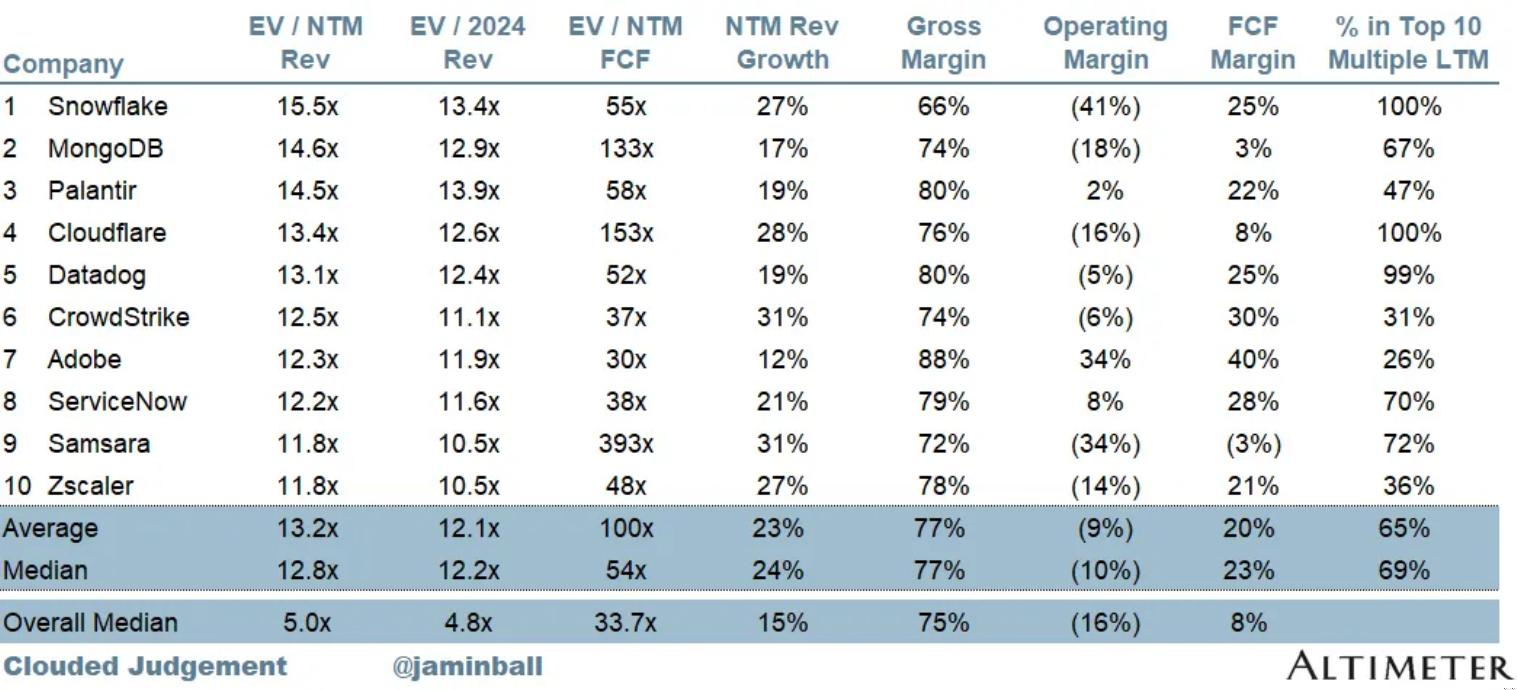

In [45]:
plt_img_base64(img_base64_list[3])

... here is the corresponding summary, which we embedded and used in similarity search.

It's pretty reasonable that this image is indeed retrieved from our `query` based on it's similarity to this summary.

In [44]:
image_summaries[3]

'The image is a data table comparing key financial metrics of ten technology companies. Metrics include Enterprise Value to Next Twelve Months Revenue (EV/NTM Rev), EV to 2024 Revenue (EV/2024 Rev), EV to NTM Free Cash Flow (EV/NTM FCF), NTM Revenue Growth, Gross Margin, Operating Margin, Free Cash Flow Margin (FCF Margin), and the percentage in Top 10 Multiple Last Twelve Months (LTM). The table lists averages and medians for these metrics, including an overall median for reference. It features the logo of Altimeter and the watermark "@jaminball" at the bottom.'

### RAG

Now let's run RAG and test the ability to synthesize an answer to our question.

In [28]:
# Run RAG chain
chain_multimodal_rag.invoke(query)

"Based on the information provided in the images, we can analyze potential investment opportunities by looking at the Enterprise Value to Next Twelve Months (EV/NTM) revenue multiples and the NTM revenue growth rates. We should also consider how these multiples compare to historical averages to understand if the companies are potentially undervalued or overvalued.\n\nFrom the first image, we can see that the median EV/NTM Revenue/NTM Growth multiples have fluctuated over time and are currently above the long-term average, suggesting that companies might be generally valued higher compared to historical norms. However, this does not preclude finding individual companies that may still be attractive investments.\n\nThe second image shows the EV/NTM Revenue Multiples for high, mid, and low growth companies. We can observe that high growth companies have experienced a significant decline from their peak multiples, which could indicate a potential investment opportunity if the growth prospe

Here is the trace where we can see what is passed to the LLM:
 
* Question 1 [Trace focused on investment advice](https://smith.langchain.com/public/d77b7b52-4128-4772-82a7-c56eb97e8b97/r)
* Question 2 [Trace focused on table extraction](https://smith.langchain.com/public/4624f086-1bd7-4284-9ca9-52fd7e7a4568/r)

For question 1, we can see that we pass 3 images along with a text chunk:

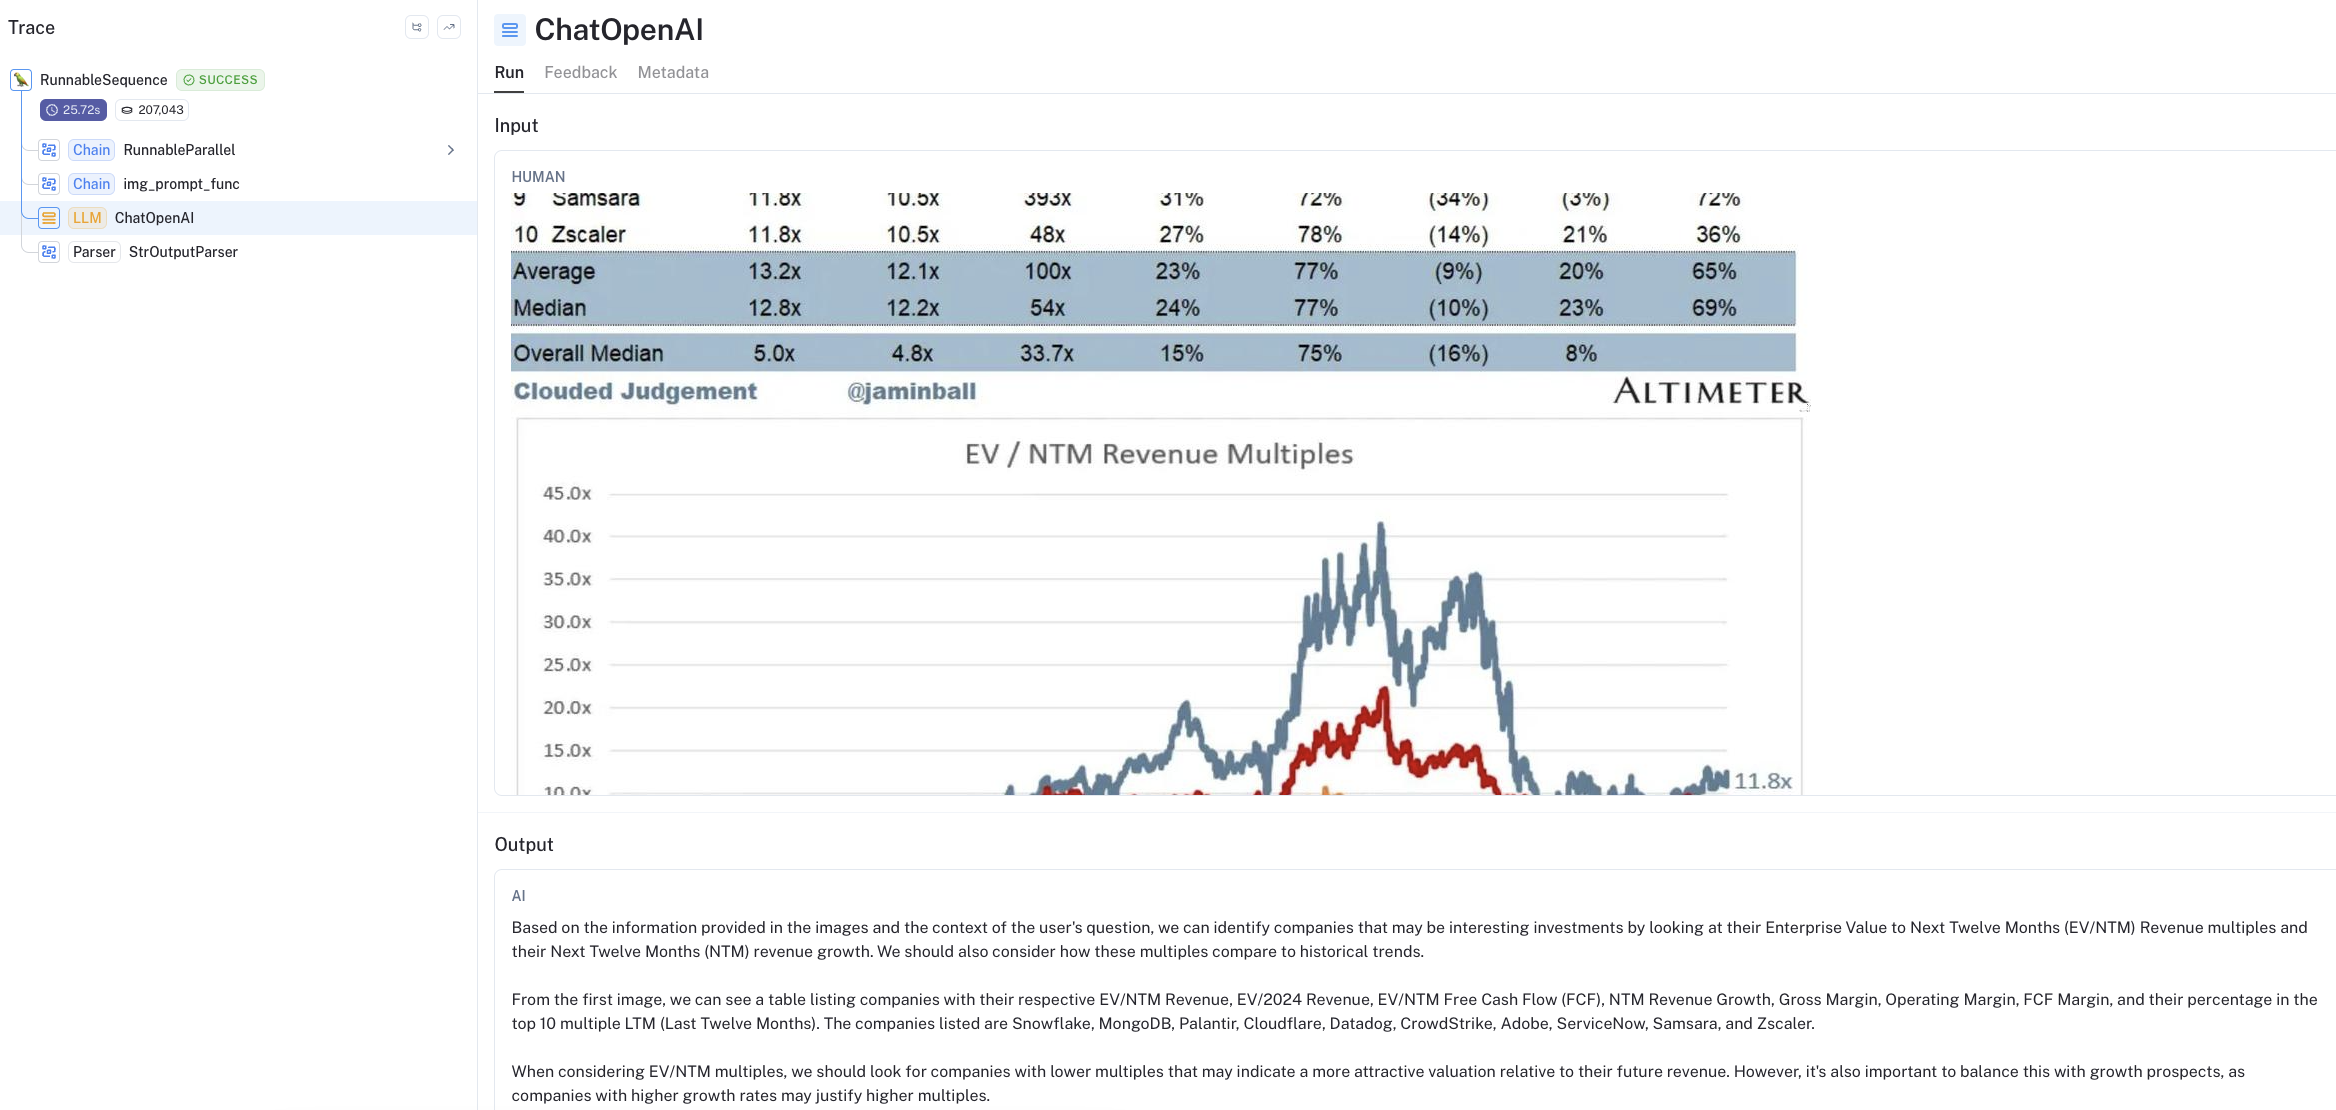

### Considerations

**Retrieval**
 
* Retrieval is performed based upon similarity to image summaries as well as text chunks.
* This requires some careful consideration because image retrieval can fail if there are competing text chunks.
* To mitigate this, I produce larger (4k token) text chunks and summarize them for retrieval.

**Image Size**

* The quality of answer synthesis appears to be sensitive to image size, [as expected](https://platform.openai.com/docs/guides/vision).
* I'll do evals soon to test this more carefully.